# PROJECT TARGET

For our culminating project, we will showcase our comprehensive abilities in various aspects of this subject, including data scraping, data preprocessing, modeling, and evaluation. The project involves creating a Generative Adversarial Network (GAN) that can generate colored images from their corresponding sketches.

# Packages Loading

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

%cd /content/drive/MyDrive/NM_KDL/Pix2Pix

Mounted at /content/drive/
/content/drive/MyDrive/NM_KDL/Pix2Pix


In [ ]:
import os
import shutil
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import img_to_array,load_img
from keras.models import load_model

from bs4 import BeautifulSoup
import urllib.request
import requests
import pandas as pd
import ssl

# Data Collection

Declare disclaimer of responsibility in data crawling, and serve solely for educational purposes.

##  Download website's components and extract image links

In [ ]:
def download_html(url):
    """
    Download html object from url.
    Input: url. Output: HTML object.
    """
    context = ssl._create_unverified_context()
    with urllib.request.urlopen(url, context=context) as response:
        html = response.read()
        html = html.decode('utf-8')
    response.close()
    return html

This task is to scrape and collect image data from the website "https://sketchy.eye.gatech.edu". The website contains a wide range of images featuring various objects and animals, including but not limited to cats, ducks, windows, and apples. Each object is represented by both a colored image and a sketched image, both of which we will be collecting and processing for use in our project.

Just take a look of this website:
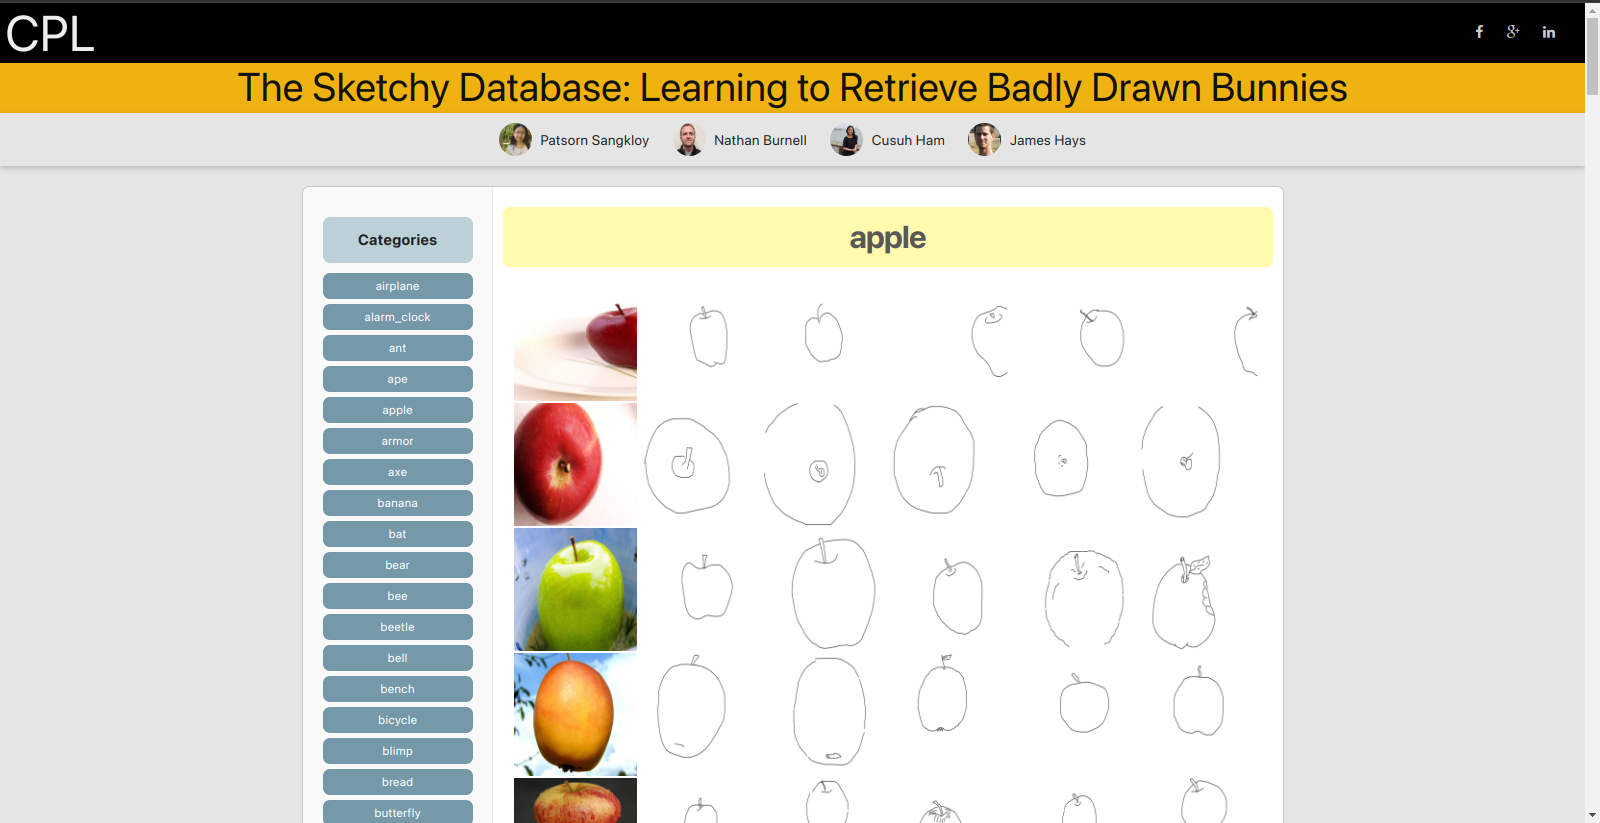

For our project, we have selected a specific set of objects that are relatively easier to generate images from. This set includes objects such as windows, zebras, wine bottles, and apples, which we will be focusing on for the purpose of image generation.

In [ ]:
# List of objects to download
objects = ['window', 'zebra', 'wine_bottle', 'apple', 'rabbit','banana','bee','bicycle','bread','cat','cow'
          ,'crab','snake','tree','strawberry','sea_turtle']

Download images.

In [ ]:
urls = [f"http://sketchy.eye.gatech.edu/explore/{obj}.html" for obj in objects]
soups = []

# Download and use BeautifulSoup to parse the HTML object
for url in urls:
    html = download_html(url)
    soup = BeautifulSoup(html, 'html.parser')
    soups.append(soup)

Next, we will extract the image links from the BeautifulSoup objects that we have created for our selected objects

In [ ]:
objects_images_url = []
objects_sketches_url = []

for i in range(len(soups)):
    soup = soups[i]
    images_tag = soup.find_all('img')
    urls = ['http://sketchy.eye.gatech.edu/explore/' + (tag.get('src')) for tag in images_tag]

    # Choose urls that contain 'photos'
    images_url = [url for url in urls if 'photos' in url]
    # Choose first urls that contain 'sketches'
    sketches_url = [url for url in urls if 'sketches' in url]
    # Take sketches_url every 5 jumps
    sketches_url = sketches_url[::5]

    print(f"{objects[i]}: {len(images_url)} images, {len(sketches_url)} sketches")
    objects_images_url.append(images_url)
    objects_sketches_url.append(sketches_url)

window: 100 images, 100 sketches
zebra: 100 images, 100 sketches
wine_bottle: 100 images, 100 sketches
apple: 100 images, 100 sketches
rabbit: 100 images, 100 sketches
banana: 100 images, 100 sketches
bee: 100 images, 100 sketches
bicycle: 100 images, 100 sketches
bread: 100 images, 100 sketches
cat: 100 images, 100 sketches
cow: 100 images, 100 sketches
crab: 100 images, 100 sketches
snake: 100 images, 100 sketches
tree: 100 images, 100 sketches
strawberry: 100 images, 100 sketches
sea_turtle: 100 images, 100 sketches


## Scrape images

In [ ]:
from io import BytesIO
from PIL import Image
from tensorflow.keras.utils import img_to_array


# From url above, download image then convert to numpy array
def download_image(url):
    """
    Download image from url, then convert to numpy array.
    Input: url. Output: np.array.
    """
    response = requests.get(url, verify=False)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB')

    return img

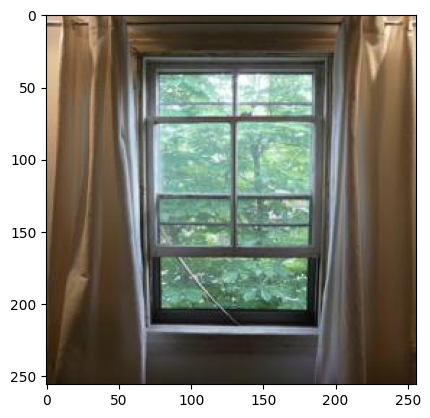

In [ ]:
# Test it:
img = download_image(objects_images_url[0][0])
plt.imshow(img)

# Convert Images into Sketches using CV2

In [ ]:
def Img2Sketch(img: np.ndarray):
    """
    Convert real image to sketched image.
    Input: image as numpy array. Output: sketched image as numpy array.
    """
    # img = cv2.imread("wbb1.jpeg")
    img = img_to_array(img)

    # # Convert image to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # # Apply Gaussian blur to the grayscale image
    # blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # blurred = np.uint8(blurred)
    # # Perform Canny edge detection
    # edges = cv2.Canny(blurred, 30, 100)

    # # Invert the edges
    # inverted_edges = cv2.bitwise_not(edges)

    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    invert = cv2.bitwise_not(grey_img)  # helps in masking of the image
    # sharp edges in images are smoothed while minimizing too much blurring
    blur = cv2.GaussianBlur(invert, (21, 21), 0)
    invertedblur = cv2.bitwise_not(blur)
    sketch = cv2.divide(grey_img, invertedblur, scale=256.0)

    return sketch

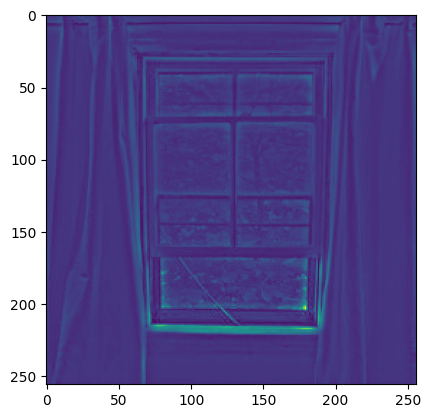

In [ ]:
# Test it:
img_sketch = Img2Sketch(img)
plt.imshow(img_sketch)
plt.show()

# Setup folder for training dataset

As we lacked sufficient scraped data for our project, we have decided to incorporate an additional source of image data, namely the Scribble dataset which can be accessed through this link: (https://paperswithcode.com/dataset/scribble). The Scribble dataset is a new set of outline images consisting of 200 images per class (150 for training and 50 for testing) for a total of 10 classes. The classes include items such as basketballs, chickens, cookies, cupcakes, moons, oranges, soccer balls, strawberries, watermelons, and pineapples. All images have a white background and were obtained by conducting keyword searches on popular search engines. For each image, we obtain rough outlines that can be further processed and used in our project.

## From Scribble dataset

In [ ]:
!wget -N "http://www.robots.ox.ac.uk/~arnabg/scribble_dataset.zip"

In [ ]:
source_folder = "./scribble_dataset"
destination_folder_A = "/content/drive/MyDrive/NM_KDL/Pix2Pix/dataset/A"
destination_folder_B = "/content/drive/MyDrive/NM_KDL/Pix2Pix/dataset/B"

# Create the destination folders if they don't exist
os.makedirs(destination_folder_A, exist_ok=True)
os.makedirs(destination_folder_B, exist_ok=True)

# Move and rename images from scrribles folder to destination folder A
source_folder_scrribles = os.path.join(source_folder, "scrribles")
for subclass in os.listdir(source_folder_scrribles):
    subclass_folder = os.path.join(source_folder_scrribles, subclass)
    if os.path.isdir(subclass_folder):
        for filename in os.listdir(subclass_folder):
            if filename.endswith(".png"):
                source_file = os.path.join(subclass_folder, filename)
                destination_file = os.path.join(destination_folder_A, f"{subclass}_{filename}")
                shutil.copy2(source_file, destination_file)

# copy2 and rename images from images folder to destination folder B
source_folder_images = os.path.join(source_folder, "images")
for subclass in os.listdir(source_folder_images):
    subclass_folder = os.path.join(source_folder_images, subclass)
    if os.path.isdir(subclass_folder):
        for filename in os.listdir(subclass_folder):
            if filename.endswith(".png"):
                source_file = os.path.join(subclass_folder, filename)
                destination_file = os.path.join(destination_folder_B, f"{subclass}_{filename}")
                shutil.copy2(source_file, destination_file)


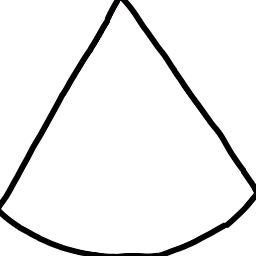

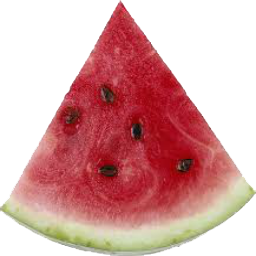

In [ ]:
from IPython.display import Image, display

display(Image('/content/drive/MyDrive/NM_KDL/Pix2Pix/dataset/A/watermelon_130.png'))
display(Image('/content/drive/MyDrive/NM_KDL/Pix2Pix/dataset/B/watermelon_130.png'))

## From Scraped dataset

In [ ]:
destination_folder_A = "/content/drive/MyDrive/NM_KDL/Pix2Pix/scraped_dataset/A"
destination_folder_B = "/content/drive/MyDrive/NM_KDL/Pix2Pix/scraped_dataset/B"

os.makedirs(destination_folder_A, exist_ok=True)
os.makedirs(destination_folder_B, exist_ok=True)

for i in range(len(objects)):
    obj = objects[i]
    print(f"Object: {obj}")

    # Download images from objects_images_url and save to destination folder B, name each file as {object}_{index+1}.png
    images_url = objects_images_url[i]
    for j, url in enumerate(images_url):
        img = download_image(url)
        img = img_to_array(img)
        destination_file = os.path.join(destination_folder_B, f"{obj}_{j+1}.png")
        cv2.imwrite(destination_file, img)
    print(f"Downloaded {len(images_url)} images for {obj}")

    # Download sketch image, then save to destination folder A, name each file as {object}_{index+1}.png
    sketches_url = objects_sketches_url[i]
    for j, url in enumerate(sketches_url):
        img_sketch = download_image(url)
        img_sketch = img_to_array(img_sketch)
        destination_file = os.path.join(destination_folder_A, f"{obj}_{j+1}.png")
        cv2.imwrite(destination_file, img_sketch)
    print(f"Downloaded {len(sketches_url)} sketches for {obj}")

Object: window
Downloaded 100 images for window
Downloaded 100 sketches for window
Object: zebra
Downloaded 100 images for zebra
Downloaded 100 sketches for zebra
Object: wine_bottle
Downloaded 100 images for wine_bottle
Downloaded 100 sketches for wine_bottle
Object: apple
Downloaded 100 images for apple
Downloaded 100 sketches for apple
Object: rabbit
Downloaded 100 images for rabbit
Downloaded 100 sketches for rabbit
Object: banana
Downloaded 100 images for banana
Downloaded 100 sketches for banana
Object: bee
Downloaded 100 images for bee
Downloaded 100 sketches for bee
Object: bicycle
Downloaded 100 images for bicycle
Downloaded 100 sketches for bicycle
Object: bread
Downloaded 100 images for bread
Downloaded 100 sketches for bread
Object: cat
Downloaded 100 images for cat
Downloaded 100 sketches for cat
Object: cow
Downloaded 100 images for cow
Downloaded 100 sketches for cow
Object: crab
Downloaded 100 images for crab
Downloaded 100 sketches for crab
Object: snake
Downloaded 100

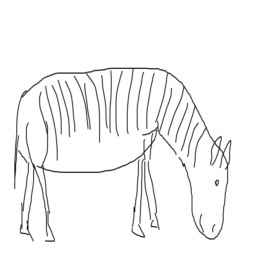

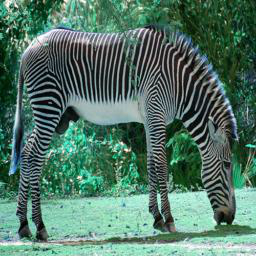

In [ ]:
from IPython.display import Image, display

display(Image('/content/drive/MyDrive/NM_KDL/Pix2Pix/scraped_dataset/A/zebra_100.png'))
display(Image('/content/drive/MyDrive/NM_KDL/Pix2Pix/scraped_dataset/B/zebra_100.png'))

# Modelings

## Utils

Select a batch of random samples, return :
+ images :np.array
+ target - using in conditional GAN , not our problems

In [ ]:
def generate_real_samples_from_disk(trainA, trainB, n_batch, n_patch):
    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_batch)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_batch, n_patch, n_patch, 1))
    return [X1, X2], y

from generator model, generate

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model,trainA,trainB, n_samples=3):
	  # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples_from_disk(trainA, trainB, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
      pyplot.subplot(3, n_samples, 1 + i)
      pyplot.axis('off')
      pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
      pyplot.subplot(3, n_samples, 1 + n_samples + i)
      pyplot.axis('off')
      pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
      pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
      pyplot.axis('off')
      pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_lastest_1epoch.png'
    pyplot.savefig(os.path.join('/content/drive/MyDrive/NM_KDL/Pix2Pix/ckpt/',filename1))
    pyplot.close()
    # save the generator model
    filename2 = "model_lastest_G_1epoch.h5"
    g_model.save(os.path.join('/content/drive/MyDrive/NM_KDL/Pix2Pix/ckpt/',filename2))

    filename3 = "model_lastest_D_1epoch.h5"
    d_model.save(os.path.join('/content/drive/MyDrive/NM_KDL/Pix2Pix/ckpt/',filename3))

    print('>Saved: %s and %s' % (filename1, filename2))


In [ ]:
from PIL import Image
def load_real_samples(folder_A, folder_B):

    X1 = []
    X2 = []
    # Load images from folder A (sketches) and folder B (corresponding images)
    for filename_A, filename_B in zip(sorted(os.listdir(folder_A)), sorted(os.listdir(folder_B))):
        if filename_A.endswith('.DS_Store') or filename_B.endswith('.DS_Store'):
            continue

        image_A = Image.open(os.path.join(folder_A, filename_A))
        image_B = Image.open(os.path.join(folder_B, filename_B))

        image_A = image_A.convert('RGB')
        image_B = image_B.convert('RGB')

        image_A = image_A.resize((256, 256))
        image_B = image_B.resize((256, 256))

        X1.append(np.array(image_A))
        X2.append(np.array(image_B))

    X1 = np.array(X1)
    X2 = np.array(X2)

    # Scale from [0, 255] to [-1, 1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
def load_image(filename, size=(256,256,3)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1] # minmax scaler
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = np.expand_dims(pixels, 0)
    return pixels

## Disciminator block

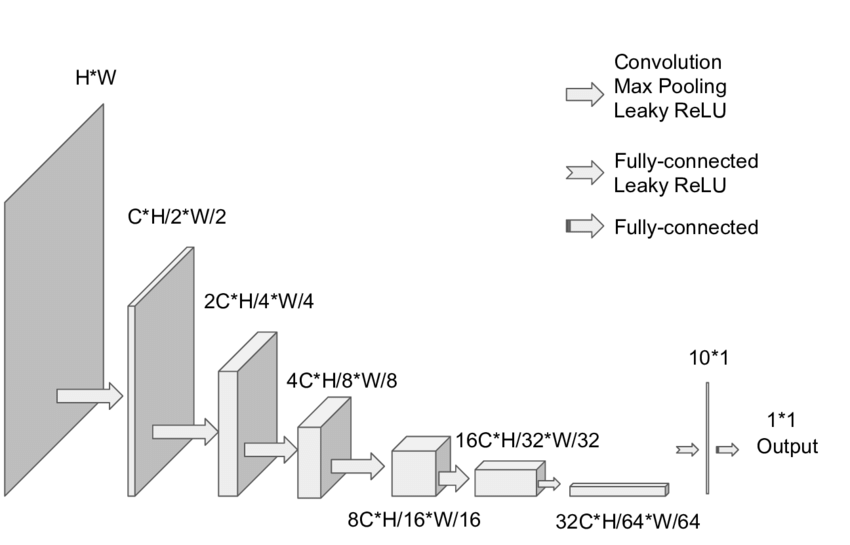

In [ ]:
from IPython.display import Image, display

display(Image('/content/drive/MyDrive/NM_KDL/dis.png'))

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

	return model

In [ ]:
dis = define_discriminator((256,256,3))
dis.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

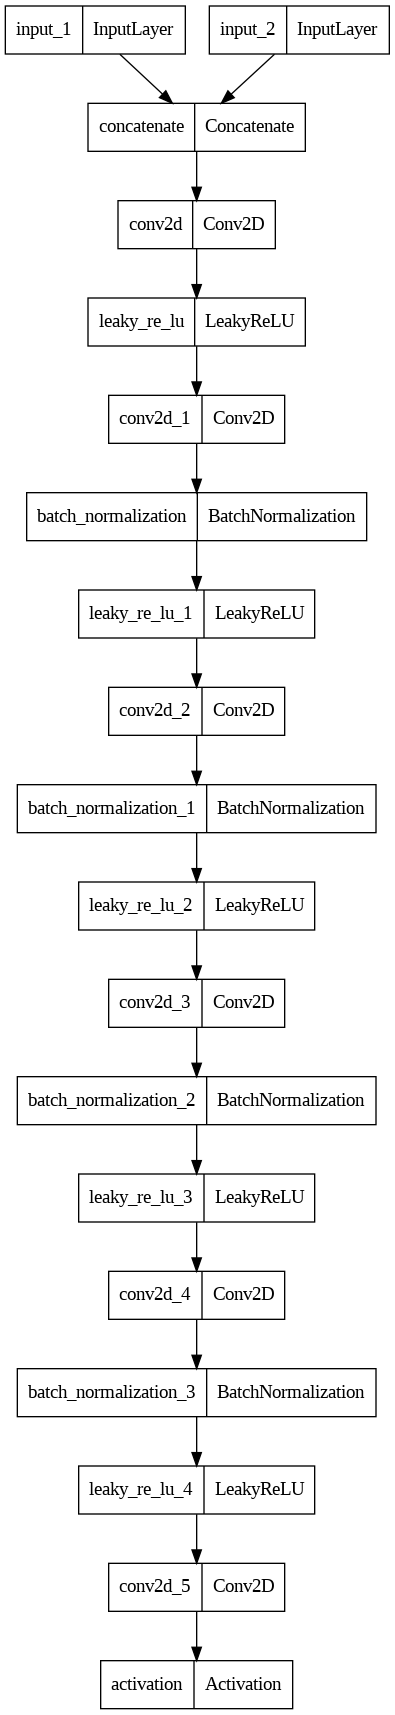

In [ ]:
plot_model(dis)

## Generator block

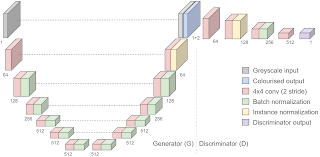

In [ ]:
from IPython.display import Image, display

display(Image('/content/drive/MyDrive/NM_KDL/gen.png'))

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [ ]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
gen = define_generator((256,256,3))
gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  3136        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_6[0][0]']               
                                )                                                           

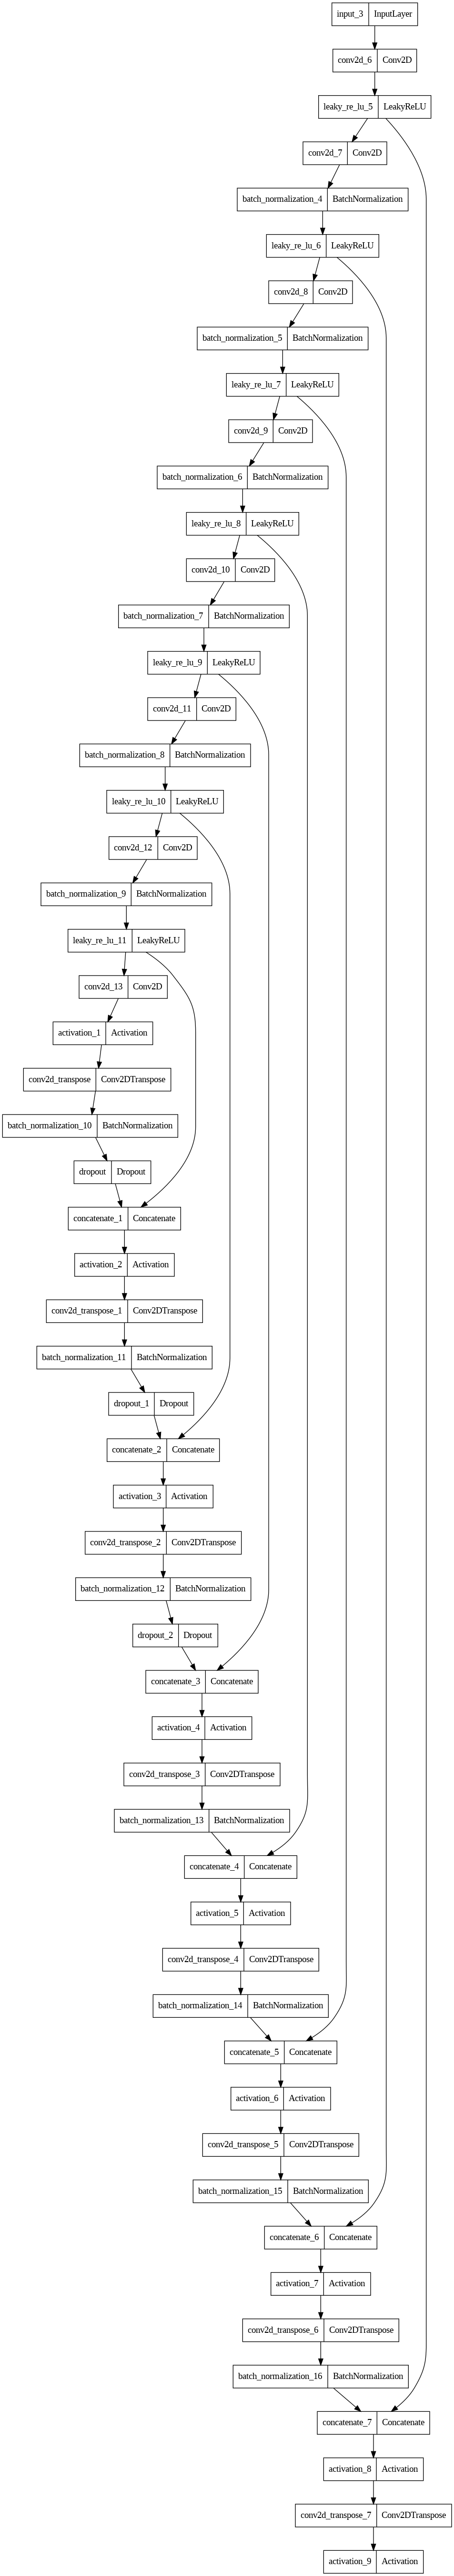

In [ ]:
plot_model(gen)

## GAN model

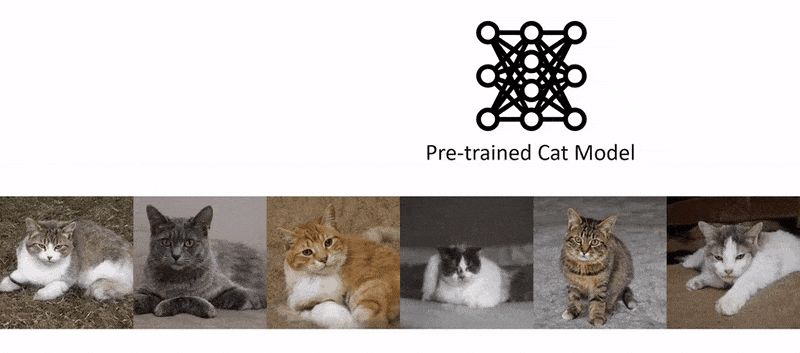

In [ ]:
display(Image('/content/drive/MyDrive/NM_KDL/Sketch-to-GAN-animation.gif'))

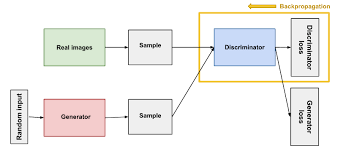

In [ ]:
from IPython.display import Image, display

display(Image('/content/drive/MyDrive/NM_KDL/gan.png'))

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
gan = define_gan(gen,dis,(256,256,3))
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 256, 256, 3)  54429315    ['input_4[0][0]']                
                                                                                                  
 model (Functional)             (None, 16, 16, 1)    6968257     ['input_4[0][0]',                
                                                                  'model_1[0][0]']                
                                                                                            

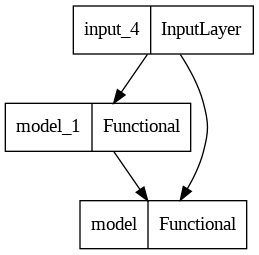

In [ ]:
plot_model(gan)

# Trainning phase

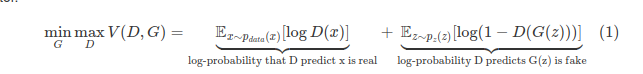

In [ ]:
from IPython.display import Image, display

display(Image('/content/drive/MyDrive/NM_KDL/loss.png'))

In [ ]:
def train(d_model, g_model, gan_model, folder_A, folder_B, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # load the training data
    trainA, trainB = load_real_samples(folder_A, folder_B)
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples_from_disk(trainA, trainB, n_batch, n_patch)

        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f] ' % (i+1, d_loss1, d_loss2, g_loss))

        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, d_model, trainA, trainB)



In [ ]:
# folder_B = f'/content/drive/MyDrive/NM_KDL/Pix2Pix/dataset/B' # target
# folder_A = f'/content/drive/MyDrive/NM_KDL/Pix2Pix/dataset/A' # sketch
folder_B = f'/content/drive/MyDrive/NM_KDL/Pix2Pix/scraped_dataset/B' # target
folder_A = f'/content/drive/MyDrive/NM_KDL/Pix2Pix/scraped_dataset/A' # sketch
len(os.listdir(folder_A)), len(os.listdir(folder_B))

(1600, 1600)

In [ ]:
# 1 epoch = 5p

# g_model = load_model('/content/drive/MyDrive/NM_KDL/Pix2Pix/ckpt/model_lastest_G.h5')
# d_model = load_model('/content/drive/MyDrive/NM_KDL/Pix2Pix/ckpt/model_lastest_D.h5')
# define the models
d_model = define_discriminator((256,256,3))
g_model = define_generator((256,256,3))
# define the composite model
gan_model = define_gan(g_model, d_model, (256,256,3))
# train model

train(d_model, g_model, gan_model, folder_A, folder_B, n_epochs=1, n_batch=16)

1/1 [==============================] - 3s 3s/step
>1, d1[0.201] d2[2.538] g[48.915] 
1/1 [==============================] - 0s 37ms/step
>2, d1[1.590] d2[1.500] g[47.481] 
1/1 [==============================] - 0s 28ms/step
>3, d1[0.744] d2[0.830] g[46.071] 
1/1 [==============================] - 0s 33ms/step
>4, d1[0.463] d2[0.517] g[46.731] 
1/1 [==============================] - 0s 35ms/step
>5, d1[0.459] d2[0.440] g[40.486] 
1/1 [==============================] - 0s 40ms/step
>6, d1[0.332] d2[0.487] g[44.786] 
1/1 [==============================] - 0s 42ms/step
>7, d1[0.321] d2[0.389] g[41.324] 
1/1 [==============================] - 0s 43ms/step
>8, d1[0.256] d2[0.419] g[50.938] 
1/1 [==============================] - 0s 33ms/step
>9, d1[0.313] d2[0.356] g[49.895] 
1/1 [==============================] - 0s 40ms/step
>10, d1[0.240] d2[0.294] g[44.274] 
1/1 [==============================] - 0s 28ms/step
>11, d1[0.206] d2[0.225] g[42.609] 
1/1 [==============================] - 0s 3

# Testing Phase

In [ ]:
g_model = load_model('/content/drive/MyDrive/NM_KDL/Pix2Pix/ckpt/model_lastest_G.h5')
d_model = load_model('/content/drive/MyDrive/NM_KDL/Pix2Pix/ckpt/model_lastest_D.h5')
src_image = load_image(f'/content/drive/MyDrive/NM_KDL/Pix2Pix/dataset/A/watermelon_148.png') # (1, 256, 256, 3)

# src_image = load_image(f'/content/drive/MyDrive/NM_KDL/Pix2Pix/scraped_dataset/A/zebra_99.png')

gen_image = g_model.predict(src_image)

1/1 [==============================] - 0s 371ms/step


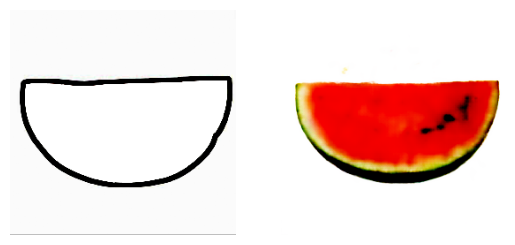

In [ ]:
from matplotlib import pyplot
f = pyplot.figure()
f.add_subplot(1,2, 1)
pyplot.imshow(src_image[0])
pyplot.axis('off')
f.add_subplot(1,2, 2)
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show(block=True)